# Extract Transform Load (ETL)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
from scipy.stats.mstats import trimmed_var
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

In [3]:
df = pd.read_csv("Data.csv")

In [4]:
df.head()

Country Name Country Code  \
0  Afghanistan          AFG   
1  Afghanistan          AFG   
2  Afghanistan          AFG   
3  Afghanistan          AFG   
4  Afghanistan          AFG   

                                         Series Name        Series Code  \
0  Access to clean fuels and technologies for coo...     EG.CFT.ACCS.ZS   
1  Access to clean fuels and technologies for coo...  EG.CFT.ACCS.RU.ZS   
2  Access to clean fuels and technologies for coo...  EG.CFT.ACCS.UR.ZS   
3            Access to electricity (% of population)     EG.ELC.ACCS.ZS   
4  Access to electricity, rural (% of rural popul...  EG.ELC.ACCS.RU.ZS   

  2019 [YR2019] 2020 [YR2020] 2021 [YR2021] 2022 [YR2022] 2023 [YR2023]  
0          32.6          33.8          34.9          36.1            ..  
1          15.6          16.4          17.4          18.5            ..  
2          83.2          83.8          84.5            85            ..  
3          97.7          97.7          97.7          85.3            ..  
4          97.1          97.1          97.1          81.7            ..

In [5]:
unique_cols = df['Series Name'].nunique()
unique_cols

1492

In [6]:
df['Series Code'][0]==df['Series Code'][1492]

True

In [7]:
df['Series Code'][1492]==df['Series Code'][2984]

True

There are 1492 unique features. This is why the 'Series Code' repeats at an interval of 1492. For our reference we save the 'Series Codes' and their 'Series Names' in a CSV file to be used as our data dictionary.

In [8]:
data_dict = df[['Series Code', 'Series Name']][:1492]
data_dict.to_csv('data_dict.csv', index=True) 

We want the rows of our data to correspond to different countries and the columns to be the feaures ('Sereis Code'). To achieve this we use pivot table for year 2019.

In [9]:
df["2019 [YR2019]"]=df["2019 [YR2019]"].replace("..", None)
df["2019 [YR2019]"] = df["2019 [YR2019]"].astype(float)

In [10]:
df_trans=pd.pivot_table(df, values="2019 [YR2019]", index="Country Name", columns="Series Code", sort=False)

In [11]:
# Remove last 48 rows as they correspond to enties like 'world' and not individual countries
df_trans=df_trans.iloc[:-48]

In [12]:
df_trans.head()

Series Code     EG.CFT.ACCS.ZS  EG.CFT.ACCS.RU.ZS  EG.CFT.ACCS.UR.ZS  \
Country Name                                                           
Afghanistan               32.6               15.6               83.2   
Albania                   82.0               64.7               93.4   
Algeria                   99.7               98.8               99.9   
American Samoa             NaN                NaN                NaN   
Andorra                  100.0              100.0              100.0   

Series Code     EG.ELC.ACCS.ZS  EG.ELC.ACCS.RU.ZS  EG.ELC.ACCS.UR.ZS  \
Country Name                                                           
Afghanistan               97.7               97.1               99.5   
Albania                  100.0              100.0              100.0   
Algeria                   99.5               98.7               99.8   
American Samoa             NaN                NaN                NaN   
Andorra                  100.0              100.0              100.0   

Series Code     NY.ADJ.NNTY.CD  NY.ADJ.NNTY.PC.CD  NY.ADJ.DCO2.GN.ZS  \
Country Name                                                           
Afghanistan       1.773194e+10         469.477760           1.290995   
Albania           1.244998e+10        4361.999293           1.295783   
Algeria           1.341336e+11        3140.907179           4.167493   
American Samoa             NaN                NaN                NaN   
Andorra                    NaN                NaN           0.588906   

Series Code     NY.ADJ.DCO2.CD  ...  SG.VAW.ARGU.ZS  SG.VAW.BURN.ZS  \
Country Name                    ...                                   
Afghanistan       2.479358e+08  ...             NaN             NaN   
Albania           1.969622e+08  ...             NaN             NaN   
Algeria           6.983390e+09  ...             NaN             NaN   
American Samoa    1.449396e+07  ...             NaN             NaN   
Andorra           2.038946e+07  ...             NaN             NaN   

Series Code     SG.VAW.GOES.ZS  SG.VAW.NEGL.ZS  SG.VAW.REFU.ZS  \
Country Name                                                     
Afghanistan                NaN             NaN             NaN   
Albania                    NaN             NaN             NaN   
Algeria                    NaN             NaN             NaN   
American Samoa             NaN             NaN             NaN   
Andorra                    NaN             NaN             NaN   

Series Code     SH.SGR.PROC.P5  DT.NFL.UNEC.CD  DT.NFL.UNEP.CD  \
Country Name                                                     
Afghanistan                NaN             NaN             NaN   
Albania                    NaN             NaN             NaN   
Algeria                    NaN             NaN             NaN   
American Samoa             NaN             NaN             NaN   
Andorra                    NaN             NaN             NaN   

Series Code     DT.NFL.UNTA.CD  DT.NFL.UNWT.CD  
Country Name                                    
Afghanistan                NaN             NaN  
Albania                    NaN             NaN  
Algeria                    NaN             NaN  
American Samoa             NaN             NaN  
Andorra                    NaN             NaN  

[5 rows x 1329 columns]

In [13]:
df_trans.shape

(217, 1329)

There are many missing values in our data. So we remove columns which have more than a threshold of missing values.

In [14]:
drop_threshold = round(0.2*len(df_trans)) # we will drop colums that have more than 60% missing values
drop_threshold

43

In [15]:
drop_cols = []
for col in df_trans.columns:
    if df_trans[col].isnull().sum()>drop_threshold:
        drop_cols.append(col)
len(drop_cols)

788

In [16]:
df_trans.drop(columns=drop_cols, axis=1, inplace=True)
df_trans.head()

Series Code     EG.CFT.ACCS.ZS  EG.CFT.ACCS.RU.ZS  EG.CFT.ACCS.UR.ZS  \
Country Name                                                           
Afghanistan               32.6               15.6               83.2   
Albania                   82.0               64.7               93.4   
Algeria                   99.7               98.8               99.9   
American Samoa             NaN                NaN                NaN   
Andorra                  100.0              100.0              100.0   

Series Code     EG.ELC.ACCS.ZS  EG.ELC.ACCS.RU.ZS  EG.ELC.ACCS.UR.ZS  \
Country Name                                                           
Afghanistan               97.7               97.1               99.5   
Albania                  100.0              100.0              100.0   
Algeria                   99.5               98.7               99.8   
American Samoa             NaN                NaN                NaN   
Andorra                  100.0              100.0              100.0   

Series Code     NY.ADJ.NNTY.CD  NY.ADJ.NNTY.PC.CD  NY.ADJ.DCO2.GN.ZS  \
Country Name                                                           
Afghanistan       1.773194e+10         469.477760           1.290995   
Albania           1.244998e+10        4361.999293           1.295783   
Algeria           1.341336e+11        3140.907179           4.167493   
American Samoa             NaN                NaN                NaN   
Andorra                    NaN                NaN           0.588906   

Series Code     NY.ADJ.DCO2.CD  ...  NE.CON.PRVT.ZS  NE.CON.PRVT.CN  \
Country Name                    ...                                   
Afghanistan       2.479358e+08  ...             NaN             NaN   
Albania           1.969622e+08  ...       80.000193    1.353526e+12   
Algeria           6.983390e+09  ...       42.800371    9.882648e+12   
American Samoa    1.449396e+07  ...       78.670788    5.090000e+08   
Andorra           2.038946e+07  ...             NaN             NaN   

Series Code     NE.CON.PRVT.CD  NE.CON.PRVT.CN.AD  NE.IMP.GNFS.ZS  \
Country Name                                                        
Afghanistan                NaN                NaN             NaN   
Albania           1.232149e+10       1.353526e+12       44.974925   
Algeria           8.280145e+10       9.882648e+12       26.098901   
American Samoa    5.090000e+08       5.090000e+08       94.899536   
Andorra                    NaN                NaN             NaN   

Series Code     NE.IMP.GNFS.CN  NE.IMP.GNFS.CD   ST.INT.ARVL  \
Country Name                                                   
Afghanistan                NaN             NaN           NaN   
Albania           7.609323e+11    6.926960e+09  6.406000e+06   
Algeria           6.026262e+12    5.049085e+10  2.371000e+06   
American Samoa    6.140000e+08    6.140000e+08  1.920000e+04   
Andorra                    NaN             NaN  8.235000e+06   

Series Code     TX.VAL.MRCH.R3.ZS  NE.TRD.GNFS.ZS  
Country Name                                       
Afghanistan                   NaN             NaN  
Albania                  0.059671       76.279195  
Algeria                  5.092246       46.506843  
American Samoa          13.116338      156.568779  
Andorra                       NaN             NaN  

[5 rows x 541 columns]

In [17]:
df_trans.isnull().sum(axis=1).sort_values().tail(10)

Country Name
Monaco                      315
American Samoa              317
Faroe Islands               318
Turks and Caicos Islands    330
Channel Islands             355
Isle of Man                 376
Northern Mariana Islands    384
British Virgin Islands      392
Gibraltar                   395
St. Martin (French part)    431
dtype: int64

In [18]:
drop_threshold = round(0.2*df_trans.shape[1]) # we will drop colums that have more than 60% missing values
drop_threshold

108

In [19]:
drop_rows = []
for row in df_trans.index:
    if df_trans.loc[row].isnull().sum()>drop_threshold:
        drop_rows.append(row)
len(drop_rows)

39

In [20]:
df_trans.drop(drop_rows, axis=0, inplace=True)
df_trans.head()

Series Code          EG.CFT.ACCS.ZS  EG.CFT.ACCS.RU.ZS  EG.CFT.ACCS.UR.ZS  \
Country Name                                                                
Afghanistan                    32.6               15.6               83.2   
Albania                        82.0               64.7               93.4   
Algeria                        99.7               98.8               99.9   
Angola                         49.0                8.2               76.8   
Antigua and Barbuda           100.0              100.0              100.0   

Series Code          EG.ELC.ACCS.ZS  EG.ELC.ACCS.RU.ZS  EG.ELC.ACCS.UR.ZS  \
Country Name                                                                
Afghanistan                    97.7               97.1               99.5   
Albania                       100.0              100.0              100.0   
Algeria                        99.5               98.7               99.8   
Angola                         45.6                NaN               72.2   
Antigua and Barbuda           100.0              100.0              100.0   

Series Code          NY.ADJ.NNTY.CD  NY.ADJ.NNTY.PC.CD  NY.ADJ.DCO2.GN.ZS  \
Country Name                                                                
Afghanistan            1.773194e+10         469.477760           1.290995   
Albania                1.244998e+10        4361.999293           1.295783   
Algeria                1.341336e+11        3140.907179           4.167493   
Angola                 4.298848e+10        1328.708143           1.630692   
Antigua and Barbuda             NaN                NaN           1.340837   

Series Code          NY.ADJ.DCO2.CD  ...  NE.CON.PRVT.ZS  NE.CON.PRVT.CN  \
Country Name                         ...                                   
Afghanistan            2.479358e+08  ...             NaN             NaN   
Albania                1.969622e+08  ...       80.000193    1.353526e+12   
Algeria                6.983390e+09  ...       42.800371    9.882648e+12   
Angola                 1.028037e+09  ...       49.936913    1.514608e+13   
Antigua and Barbuda    2.120504e+07  ...             NaN             NaN   

Series Code          NE.CON.PRVT.CD  NE.CON.PRVT.CN.AD  NE.IMP.GNFS.ZS  \
Country Name                                                             
Afghanistan                     NaN                NaN             NaN   
Albania                1.232149e+10       1.353526e+12       44.974925   
Algeria                8.280145e+10       9.882648e+12       26.098901   
Angola                 3.540425e+10       1.514608e+13       17.038783   
Antigua and Barbuda             NaN                NaN       68.416533   

Series Code          NE.IMP.GNFS.CN  NE.IMP.GNFS.CD  ST.INT.ARVL  \
Country Name                                                       
Afghanistan                     NaN             NaN          NaN   
Albania                7.609323e+11    6.926960e+09    6406000.0   
Algeria                6.026262e+12    5.049085e+10    2371000.0   
Angola                 5.167936e+12    1.208015e+10     218000.0   
Antigua and Barbuda    3.187150e+09    1.180426e+09    1035000.0   

Series Code          TX.VAL.MRCH.R3.ZS  NE.TRD.GNFS.ZS  
Country Name                                            
Afghanistan                        NaN             NaN  
Albania                       0.059671       76.279195  
Algeria                       5.092246       46.506843  
Angola                        1.071941       57.829538  
Antigua and Barbuda           1.317628      137.625176  

[5 rows x 541 columns]

In [21]:
df_trans.shape

(178, 541)

In [22]:
'Gibraltar' not in df_trans.index

True

# Split data into feature matrix (X) and target vector (y)

In [23]:
target = 'EN.ATM.CO2E.PC' # CO2 emissions (metric tons per capita)
y = df_trans[target] 
y.isnull().sum()

2

In [24]:
y.head()

Country Name
Afghanistan            0.297564
Albania                1.749462
Algeria                3.994402
Angola                 0.753638
Antigua and Barbuda    5.525582
Name: EN.ATM.CO2E.PC, dtype: float64

In [25]:
leak_columns=list(data_dict.loc[189:205]['Series Code'])
drop_cols=[]
for col in leak_columns:
    if col in df_trans.columns:
        drop_cols.append(col)

In [26]:
X = df_trans.drop(drop_cols, axis=1)
X.head()

Series Code          EG.CFT.ACCS.ZS  EG.CFT.ACCS.RU.ZS  EG.CFT.ACCS.UR.ZS  \
Country Name                                                                
Afghanistan                    32.6               15.6               83.2   
Albania                        82.0               64.7               93.4   
Algeria                        99.7               98.8               99.9   
Angola                         49.0                8.2               76.8   
Antigua and Barbuda           100.0              100.0              100.0   

Series Code          EG.ELC.ACCS.ZS  EG.ELC.ACCS.RU.ZS  EG.ELC.ACCS.UR.ZS  \
Country Name                                                                
Afghanistan                    97.7               97.1               99.5   
Albania                       100.0              100.0              100.0   
Algeria                        99.5               98.7               99.8   
Angola                         45.6                NaN               72.2   
Antigua and Barbuda           100.0              100.0              100.0   

Series Code          NY.ADJ.NNTY.CD  NY.ADJ.NNTY.PC.CD  NY.ADJ.DCO2.GN.ZS  \
Country Name                                                                
Afghanistan            1.773194e+10         469.477760           1.290995   
Albania                1.244998e+10        4361.999293           1.295783   
Algeria                1.341336e+11        3140.907179           4.167493   
Angola                 4.298848e+10        1328.708143           1.630692   
Antigua and Barbuda             NaN                NaN           1.340837   

Series Code          NY.ADJ.DCO2.CD  ...  NE.CON.PRVT.ZS  NE.CON.PRVT.CN  \
Country Name                         ...                                   
Afghanistan            2.479358e+08  ...             NaN             NaN   
Albania                1.969622e+08  ...       80.000193    1.353526e+12   
Algeria                6.983390e+09  ...       42.800371    9.882648e+12   
Angola                 1.028037e+09  ...       49.936913    1.514608e+13   
Antigua and Barbuda    2.120504e+07  ...             NaN             NaN   

Series Code          NE.CON.PRVT.CD  NE.CON.PRVT.CN.AD  NE.IMP.GNFS.ZS  \
Country Name                                                             
Afghanistan                     NaN                NaN             NaN   
Albania                1.232149e+10       1.353526e+12       44.974925   
Algeria                8.280145e+10       9.882648e+12       26.098901   
Angola                 3.540425e+10       1.514608e+13       17.038783   
Antigua and Barbuda             NaN                NaN       68.416533   

Series Code          NE.IMP.GNFS.CN  NE.IMP.GNFS.CD  ST.INT.ARVL  \
Country Name                                                       
Afghanistan                     NaN             NaN          NaN   
Albania                7.609323e+11    6.926960e+09    6406000.0   
Algeria                6.026262e+12    5.049085e+10    2371000.0   
Angola                 5.167936e+12    1.208015e+10     218000.0   
Antigua and Barbuda    3.187150e+09    1.180426e+09    1035000.0   

Series Code          TX.VAL.MRCH.R3.ZS  NE.TRD.GNFS.ZS  
Country Name                                            
Afghanistan                        NaN             NaN  
Albania                       0.059671       76.279195  
Algeria                       5.092246       46.506843  
Angola                        1.071941       57.829538  
Antigua and Barbuda           1.317628      137.625176  

[5 rows x 536 columns]

In [27]:
'EN.ATM.CO2E.PC' in X.columns

False

# Feature Selection

## Feature Scaling

In [28]:
# Instantiate transformer
ss = StandardScaler()

# Transform `X`
X_scaled_data = ss.fit_transform(X)

# Put `X_scaled_data` into DataFrame
X_scaled = pd.DataFrame(X_scaled_data, columns=X.columns, index=X.index)

print("X_scaled type:", type(X_scaled))
print("X_scaled shape:", X_scaled.shape)
X_scaled.head()

X_scaled type: <class 'pandas.core.frame.DataFrame'>
X_scaled shape: (178, 536)


Series Code          EG.CFT.ACCS.ZS  EG.CFT.ACCS.RU.ZS  EG.CFT.ACCS.UR.ZS  \
Country Name                                                                
Afghanistan               -0.968599          -1.091693           0.182584   
Albania                    0.358563           0.096619           0.489547   
Algeria                    0.834084           0.921903           0.685161   
Angola                    -0.528003          -1.270787          -0.010020   
Antigua and Barbuda        0.842144           0.950945           0.688170   

Series Code          EG.ELC.ACCS.ZS  EG.ELC.ACCS.RU.ZS  EG.ELC.ACCS.UR.ZS  \
Country Name                                                                
Afghanistan                0.506147           0.517198           0.453414   
Albania                    0.597851           0.607036           0.488972   
Algeria                    0.577916           0.566764           0.474749   
Angola                    -1.571169                NaN          -1.488090   
Antigua and Barbuda        0.597851           0.607036           0.488972   

Series Code          NY.ADJ.NNTY.CD  NY.ADJ.NNTY.PC.CD  NY.ADJ.DCO2.GN.ZS  \
Country Name                                                                
Afghanistan               -0.225881          -0.724623          -0.349662   
Albania                   -0.229047          -0.461015          -0.346184   
Algeria                   -0.156101          -0.543710           1.740281   
Angola                    -0.210740          -0.666434          -0.102853   
Antigua and Barbuda             NaN                NaN          -0.313449   

Series Code          NY.ADJ.DCO2.CD  ...  NE.CON.PRVT.ZS  NE.CON.PRVT.CN  \
Country Name                         ...                                   
Afghanistan               -0.202235  ...             NaN             NaN   
Albania                   -0.203616  ...        1.164623       -0.145418   
Algeria                   -0.019791  ...       -1.333647       -0.138984   
Angola                    -0.181105  ...       -0.854370       -0.135013   
Antigua and Barbuda       -0.208377  ...             NaN             NaN   

Series Code          NE.CON.PRVT.CD  NE.CON.PRVT.CN.AD  NE.IMP.GNFS.ZS  \
Country Name                                                             
Afghanistan                     NaN                NaN             NaN   
Albania                   -0.230149          -0.145418       -0.045800   
Algeria                   -0.174471          -0.138984       -0.730106   
Angola                    -0.211914          -0.135013       -1.058560   
Antigua and Barbuda             NaN                NaN        0.804020   

Series Code          NE.IMP.GNFS.CN  NE.IMP.GNFS.CD  ST.INT.ARVL  \
Country Name                                                       
Afghanistan                     NaN             NaN          NaN   
Albania                   -0.145800       -0.376471    -0.249074   
Algeria                   -0.139146       -0.259559    -0.380662   
Angola                    -0.140231       -0.362641    -0.450875   
Antigua and Barbuda       -0.146757       -0.391893    -0.424232   

Series Code          TX.VAL.MRCH.R3.ZS  NE.TRD.GNFS.ZS  
Country Name                                            
Afghanistan                        NaN             NaN  
Albania                      -0.476935       -0.220090  
Algeria                       0.054478       -0.730949  
Angola                       -0.370045       -0.536665  
Antigua and Barbuda          -0.344102        0.832536  

[5 rows x 536 columns]

In [29]:
X_scaled_summary = X_scaled.aggregate(["mean","std"]).astype(int)

print("X_scaled_summary type:", type(X_scaled_summary))
print("X_scaled_summary shape:", X_scaled_summary.shape)
X_scaled_summary

X_scaled_summary type: <class 'pandas.core.frame.DataFrame'>
X_scaled_summary shape: (2, 536)


Series Code  EG.CFT.ACCS.ZS  EG.CFT.ACCS.RU.ZS  EG.CFT.ACCS.UR.ZS  \
mean                      0                  0                  0   
std                       1                  1                  1   

Series Code  EG.ELC.ACCS.ZS  EG.ELC.ACCS.RU.ZS  EG.ELC.ACCS.UR.ZS  \
mean                      0                  0                  0   
std                       1                  1                  1   

Series Code  NY.ADJ.NNTY.CD  NY.ADJ.NNTY.PC.CD  NY.ADJ.DCO2.GN.ZS  \
mean                      0                  0                  0   
std                       1                  1                  1   

Series Code  NY.ADJ.DCO2.CD  ...  NE.CON.PRVT.ZS  NE.CON.PRVT.CN  \
mean                      0  ...               0               0   
std                       1  ...               1               1   

Series Code  NE.CON.PRVT.CD  NE.CON.PRVT.CN.AD  NE.IMP.GNFS.ZS  \
mean                      0                  0               0   
std                       1                  1               1   

Series Code  NE.IMP.GNFS.CN  NE.IMP.GNFS.CD  ST.INT.ARVL  TX.VAL.MRCH.R3.ZS  \
mean                      0               0            0                  0   
std                       1               1            1                  1   

Series Code  NE.TRD.GNFS.ZS  
mean                      0  
std                       1  

[2 rows x 536 columns]

## Correlation with target

In [30]:
target_corr = abs(X_scaled.corrwith(y)).sort_values()

In [31]:
fig = px.bar(target_corr.tail(400))
fig.update_layout(xaxis_title='Series Code', yaxis_title='Correlation with Target')
fig.show();

In [32]:
var=list(target_corr.tail(25).index)
var

['NY.GNP.PCAP.CD',
 'NY.ADJ.NNTY.PC.CD',
 'SL.EMP.VULN.FE.ZS',
 'SP.POP.4549.MA.5Y',
 'SL.EMP.SELF.FE.ZS',
 'SL.EMP.WORK.FE.ZS',
 'SP.POP.1564.TO.ZS',
 'SL.EMP.VULN.ZS',
 'SP.POP.4044.FE.5Y',
 'SL.EMP.VULN.MA.ZS',
 'SP.POP.1014.MA.5Y',
 'SL.EMP.SELF.ZS',
 'SL.EMP.WORK.ZS',
 'SP.POP.3539.FE.5Y',
 'SL.EMP.SELF.MA.ZS',
 'SL.EMP.WORK.MA.ZS',
 'IT.NET.USER.ZS',
 'SL.GDP.PCAP.EM.KD',
 'SP.POP.1564.MA.ZS',
 'SP.POP.1519.MA.5Y',
 'SP.POP.4044.MA.5Y',
 'NY.GDP.PCAP.PP.KD',
 'NY.GDP.PCAP.PP.CD',
 'SP.POP.3539.MA.5Y',
 'NY.GNP.PCAP.PP.CD']

In [33]:
var_dict=data_dict

In [34]:
var_dict[var_dict["Series Code"]=="EG.CFT.ACCS.ZS"]["Series Name"]

0    Access to clean fuels and technologies for coo...
Name: Series Name, dtype: object

In [35]:
# var_names
for i in var[:-26:-1]:
    print(var_dict[var_dict["Series Code"]==i]["Series Name"])    

511    GNI per capita, PPP (current international $)
Name: Series Name, dtype: object
1047    Population ages 35-39, male (% of male populat...
Name: Series Name, dtype: object
485    GDP per capita, PPP (current international $)
Name: Series Name, dtype: object
484    GDP per capita, PPP (constant 2021 internation...
Name: Series Name, dtype: object
1049    Population ages 40-44, male (% of male populat...
Name: Series Name, dtype: object
1033    Population ages 15-19, male (% of male populat...
Name: Series Name, dtype: object
1038    Population ages 15-64, male (% of male populat...
Name: Series Name, dtype: object
486    GDP per person employed (constant 2021 PPP $)
Name: Series Name, dtype: object
627    Individuals using the Internet (% of population)
Name: Series Name, dtype: object
1474    Wage and salaried workers, male (% of male emp...
Name: Series Name, dtype: object
1282    Self-employed, male (% of male employment) (mo...
Name: Series Name, dtype: object
1046    Populatio

In [36]:
corr_columns=list(target_corr.tail(600).index)

In [37]:
# corr_columns

## Multicolinearity Analysis

In [38]:
X_scaled = X_scaled[corr_columns]

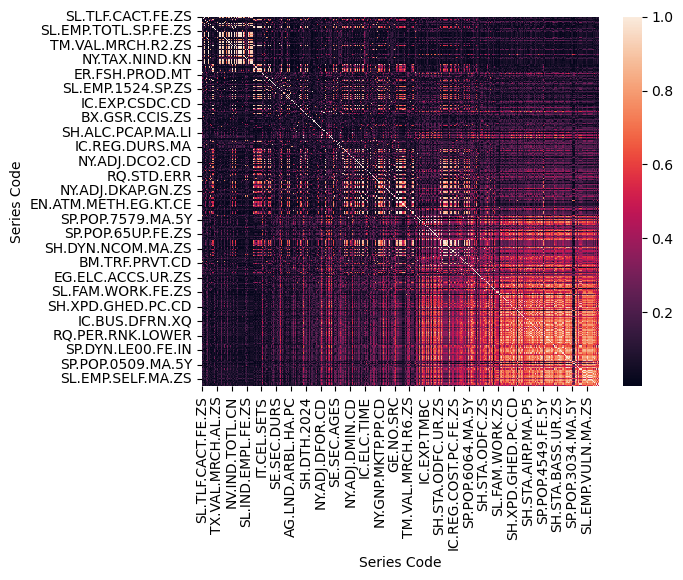

In [39]:
# Create correlation matrix
correlation = X_scaled.select_dtypes("number").corr().abs()
correlation
# Plot heatmap of `correlation`
sns.heatmap(correlation);

In [40]:
# Drop features with high correlation
threshold = 0.98
# Select upper triangle of correlation matrix
upper = correlation.where(np.triu(np.ones(correlation.shape), k=1).astype(bool))

# Find features with correlation greater than threshold
to_drop = [column for column in upper.columns if any(upper[column] >= threshold)]

In [41]:
X_reduced = X_scaled.drop(to_drop, axis=1)
X_reduced.head()

Series Code          SL.TLF.CACT.FE.ZS  PA.NUS.PPP  TT.PRI.MRCH.XD.WD  \
Country Name                                                            
Afghanistan                  -2.297176   -0.181057           1.016482   
Albania                       0.128924   -0.167711           0.217014   
Algeria                      -2.434368   -0.168841          -0.013203   
Angola                        1.550899   -0.123851           2.470513   
Antigua and Barbuda                NaN   -0.187908          -1.123515   

Series Code          EN.ATM.METH.AG.KT.CE  BN.KLT.DINV.CD  SL.UEM.1524.FE.ZS  \
Country Name                                                                   
Afghanistan                     -0.166107        0.060652           0.106442   
Albania                         -0.318172        0.018750           0.484347   
Algeria                         -0.226685        0.011946           1.863732   
Angola                          -0.024236        0.123513           0.709956   
Antigua and Barbuda             -0.351456        0.055465                NaN   

Series Code          SL.EMP.MPYR.MA.ZS  SL.EMP.1524.SP.FE.ZS  NV.AGR.TOTL.KN  \
Country Name                                                                   
Afghanistan                  -0.863303             -1.050589       -0.134953   
Albania                       0.124780             -0.533862       -0.135894   
Algeria                       0.091847             -1.684730       -0.120951   
Angola                        0.596135              0.518908       -0.136875   
Antigua and Barbuda                NaN                   NaN       -0.137572   

Series Code          BN.CAB.XOKA.CD  ...  SP.POP.4549.MA.5Y  \
Country Name                         ...                      
Afghanistan               -0.121374  ...          -1.554786   
Albania                   -0.067549  ...           0.121046   
Algeria                   -0.396713  ...           0.137950   
Angola                     0.065416  ...          -1.503504   
Antigua and Barbuda       -0.044401  ...           0.894065   

Series Code          SP.POP.4044.FE.5Y  SP.POP.1014.MA.5Y  SP.POP.3539.FE.5Y  \
Country Name                                                                   
Afghanistan                  -1.718728           1.566039          -1.749860   
Albania                      -0.294675          -0.939566          -0.857656   
Algeria                       0.631956          -0.090709           1.103943   
Angola                       -1.479568           1.363853          -1.275553   
Antigua and Barbuda           0.904756          -0.420564           0.316252   

Series Code          IT.NET.USER.ZS  SL.GDP.PCAP.EM.KD  SP.POP.1519.MA.5Y  \
Country Name                                                                
Afghanistan               -1.657374          -0.861255           1.642157   
Albania                    0.264189          -0.416093          -0.440070   
Algeria                   -0.096844           0.148700          -0.553590   
Angola                    -1.109407          -0.631129           0.918382   
Antigua and Barbuda        1.288407                NaN          -0.165205   

Series Code          SP.POP.4044.MA.5Y  NY.GDP.PCAP.PP.KD  SP.POP.3539.MA.5Y  
Country Name                                                                  
Afghanistan                  -1.503203          -0.880696          -1.402883  
Albania                      -0.479765          -0.376518          -0.612166  
Algeria                       0.442259          -0.368293           0.713210  
Angola                       -1.396136          -0.661152          -1.116799  
Antigua and Barbuda           0.434024           0.205919           0.187243  

[5 rows x 367 columns]

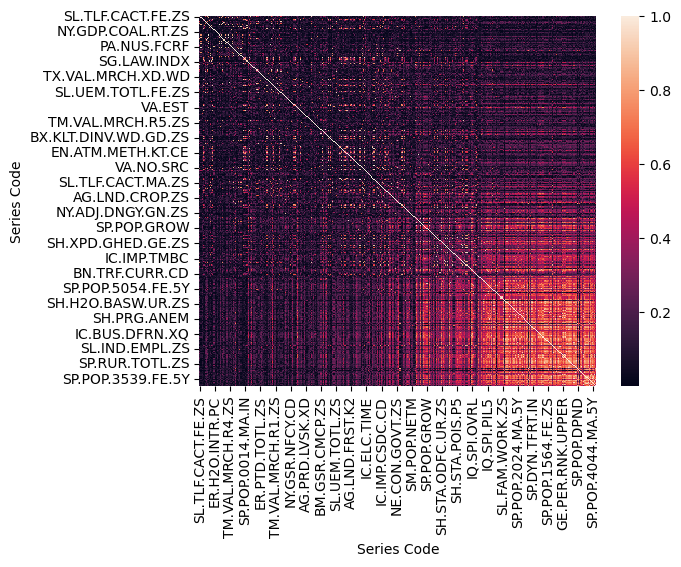

In [42]:
sns.heatmap(X_reduced.select_dtypes("number").corr().abs());

## Correlation with target

In [43]:
target_corr = abs(X_reduced.corrwith(y)).sort_values()

In [44]:
fig = px.bar(target_corr)
fig.update_layout(xaxis_title='Series Code', yaxis_title='Correlation with Target')

fig.show();

In [45]:
var = list(target_corr.tail(25).index)

In [46]:
var_dict=data_dict

In [47]:
for i in var[:-26:-1]:
    print(var_dict[var_dict["Series Code"]==i]["Series Name"])    

1047    Population ages 35-39, male (% of male populat...
Name: Series Name, dtype: object
484    GDP per capita, PPP (constant 2021 internation...
Name: Series Name, dtype: object
1049    Population ages 40-44, male (% of male populat...
Name: Series Name, dtype: object
1033    Population ages 15-19, male (% of male populat...
Name: Series Name, dtype: object
486    GDP per person employed (constant 2021 PPP $)
Name: Series Name, dtype: object
627    Individuals using the Internet (% of population)
Name: Series Name, dtype: object
1046    Population ages 35-39, female (% of female pop...
Name: Series Name, dtype: object
1031    Population ages 10-14, male (% of male populat...
Name: Series Name, dtype: object
1048    Population ages 40-44, female (% of female pop...
Name: Series Name, dtype: object
1051    Population ages 45-49, male (% of male populat...
Name: Series Name, dtype: object
1470    Vulnerable employment, female (% of female emp...
Name: Series Name, dtype: object
479    

In [48]:
# corr_threshold = 0.2 # Remove features that have a correlation less than 'corr_threshold' with the target

In [49]:
# drop_cols = []
# for col in X_reduced.columns:
#     if target_corr[col]<corr_threshold:
#         drop_cols.append(col)
# len(drop_cols)

In [50]:
# X_reduced.drop(drop_cols, axis=1, inplace=True)
# X_reduced.head()

In [51]:
target_corr = abs(X_reduced.corrwith(y)).sort_values()

In [52]:
fig = px.bar(target_corr)
fig.update_layout(xaxis_title='Series Code', yaxis_title='Correlation with Target')

fig.show();

In [53]:
target_corr.tail()

Series Code
SL.GDP.PCAP.EM.KD    0.684032
SP.POP.1519.MA.5Y    0.694574
SP.POP.4044.MA.5Y    0.732880
NY.GDP.PCAP.PP.KD    0.736565
SP.POP.3539.MA.5Y    0.761202
dtype: float64

In [54]:
y.describe()

count    176.000000
mean       4.139980
std        4.760857
min        0.033715
25%        0.813983
50%        2.828378
75%        5.599891
max       31.877203
Name: EN.ATM.CO2E.PC, dtype: float64

In [55]:
px.box(y, orientation='h')

In [56]:
high_corr_series_codes=list(target_corr.index)
high_corr_series_codes.reverse()

In [57]:
# print(high_corr_series_codes)

## Variance Analysis

In [58]:
var=X_reduced.var().sort_values()

In [59]:
var

Series Code
SE.PRM.AGES          1.005650
NY.GDP.PETR.RT.ZS    1.005650
IQ.SPI.PIL1          1.005650
RL.STD.ERR           1.005650
IT.NET.SECR.P6       1.005650
                       ...   
SH.H2O.BASW.UR.ZS    1.006289
NE.CON.GOVT.ZS       1.006329
NE.CON.PRVT.ZS       1.006329
SH.STA.ODFC.UR.ZS    1.006329
ST.INT.ARVL          1.006494
Length: 367, dtype: float64

# Handling Missing Values

### Remove rows with missing target values

In [60]:
y.isnull().sum()

2

In [61]:
y.isnull()

Country Name
Afghanistan            False
Albania                False
Algeria                False
Angola                 False
Antigua and Barbuda    False
                       ...  
Vanuatu                False
Viet Nam               False
West Bank and Gaza      True
Zambia                 False
Zimbabwe               False
Name: EN.ATM.CO2E.PC, Length: 178, dtype: bool

In [62]:
'Afghanistan' in y.index

True

In [63]:
drop_rows = []
for country in y.index:
    if y.isnull()[country]:
        drop_rows.append(country)
len(drop_rows)

2

In [64]:
print(drop_rows)

['Hong Kong SAR, China', 'West Bank and Gaza']


In [65]:
X_reduced.head(10)

Series Code          SL.TLF.CACT.FE.ZS  PA.NUS.PPP  TT.PRI.MRCH.XD.WD  \
Country Name                                                            
Afghanistan                  -2.297176   -0.181057           1.016482   
Albania                       0.128924   -0.167711           0.217014   
Algeria                      -2.434368   -0.168841          -0.013203   
Angola                        1.550899   -0.123851           2.470513   
Antigua and Barbuda                NaN   -0.187908          -1.123515   
Argentina                    -0.068122   -0.178256           0.152639   
Armenia                       0.468026   -0.111801           1.220231   
Australia                     0.702931   -0.188150           2.863946   
Austria                       0.364040   -0.188527          -0.429272   
Azerbaijan                    1.038297   -0.188657           1.077801   

Series Code          EN.ATM.METH.AG.KT.CE  BN.KLT.DINV.CD  SL.UEM.1524.FE.ZS  \
Country Name                                                                   
Afghanistan                     -0.166107        0.060652           0.106442   
Albania                         -0.318172        0.018750           0.484347   
Algeria                         -0.226685        0.011946           1.863732   
Angola                          -0.024236        0.123513           0.709956   
Antigua and Barbuda             -0.351456        0.055465                NaN   
Argentina                        1.205343       -0.124004           0.655503   
Armenia                         -0.339670        0.052149           0.309924   
Australia                        0.958829       -1.013868          -0.540395   
Austria                         -0.266627        0.248753          -0.717817   
Azerbaijan                      -0.280874        0.093948          -0.397964   

Series Code          SL.EMP.MPYR.MA.ZS  SL.EMP.1524.SP.FE.ZS  NV.AGR.TOTL.KN  \
Country Name                                                                   
Afghanistan                  -0.863303             -1.050589       -0.134953   
Albania                       0.124780             -0.533862       -0.135894   
Algeria                       0.091847             -1.684730       -0.120951   
Angola                        0.596135              0.518908       -0.136875   
Antigua and Barbuda                NaN                   NaN       -0.137572   
Argentina                     0.198112             -0.482110       -0.137219   
Armenia                      -0.940985              0.202266       -0.132675   
Australia                     1.397785              2.009227       -0.137268   
Austria                       0.937751              1.213107       -0.137546   
Azerbaijan                    4.406178              0.672779       -0.137561   

Series Code          BN.CAB.XOKA.CD  ...  SP.POP.4549.MA.5Y  \
Country Name                         ...                      
Afghanistan               -0.121374  ...          -1.554786   
Albania                   -0.067549  ...           0.121046   
Algeria                   -0.396713  ...           0.137950   
Angola                     0.065416  ...          -1.503504   
Antigua and Barbuda       -0.044401  ...           0.894065   
Argentina                 -0.115110  ...           0.124129   
Armenia                   -0.062156  ...          -0.452959   
Australia                  0.059953  ...           0.562686   
Austria                    0.180433  ...           0.953450   
Azerbaijan                 0.045668  ...           0.129115   

Series Code          SP.POP.4044.FE.5Y  SP.POP.1014.MA.5Y  SP.POP.3539.FE.5Y  \
Country Name                                                                   
Afghanistan                  -1.718728           1.566039          -1.749860   
Albania                      -0.294675          -0.939566          -0.857656   
Algeria                       0.631956          -0.090709           1.103943   
Angola                       -1.479568      

In [66]:
X_reduced=X_reduced.drop(drop_rows, axis=0)
X_reduced.head(10)

Series Code          SL.TLF.CACT.FE.ZS  PA.NUS.PPP  TT.PRI.MRCH.XD.WD  \
Country Name                                                            
Afghanistan                  -2.297176   -0.181057           1.016482   
Albania                       0.128924   -0.167711           0.217014   
Algeria                      -2.434368   -0.168841          -0.013203   
Angola                        1.550899   -0.123851           2.470513   
Antigua and Barbuda                NaN   -0.187908          -1.123515   
Argentina                    -0.068122   -0.178256           0.152639   
Armenia                       0.468026   -0.111801           1.220231   
Australia                     0.702931   -0.188150           2.863946   
Austria                       0.364040   -0.188527          -0.429272   
Azerbaijan                    1.038297   -0.188657           1.077801   

Series Code          EN.ATM.METH.AG.KT.CE  BN.KLT.DINV.CD  SL.UEM.1524.FE.ZS  \
Country Name                                                                   
Afghanistan                     -0.166107        0.060652           0.106442   
Albania                         -0.318172        0.018750           0.484347   
Algeria                         -0.226685        0.011946           1.863732   
Angola                          -0.024236        0.123513           0.709956   
Antigua and Barbuda             -0.351456        0.055465                NaN   
Argentina                        1.205343       -0.124004           0.655503   
Armenia                         -0.339670        0.052149           0.309924   
Australia                        0.958829       -1.013868          -0.540395   
Austria                         -0.266627        0.248753          -0.717817   
Azerbaijan                      -0.280874        0.093948          -0.397964   

Series Code          SL.EMP.MPYR.MA.ZS  SL.EMP.1524.SP.FE.ZS  NV.AGR.TOTL.KN  \
Country Name                                                                   
Afghanistan                  -0.863303             -1.050589       -0.134953   
Albania                       0.124780             -0.533862       -0.135894   
Algeria                       0.091847             -1.684730       -0.120951   
Angola                        0.596135              0.518908       -0.136875   
Antigua and Barbuda                NaN                   NaN       -0.137572   
Argentina                     0.198112             -0.482110       -0.137219   
Armenia                      -0.940985              0.202266       -0.132675   
Australia                     1.397785              2.009227       -0.137268   
Austria                       0.937751              1.213107       -0.137546   
Azerbaijan                    4.406178              0.672779       -0.137561   

Series Code          BN.CAB.XOKA.CD  ...  SP.POP.4549.MA.5Y  \
Country Name                         ...                      
Afghanistan               -0.121374  ...          -1.554786   
Albania                   -0.067549  ...           0.121046   
Algeria                   -0.396713  ...           0.137950   
Angola                     0.065416  ...          -1.503504   
Antigua and Barbuda       -0.044401  ...           0.894065   
Argentina                 -0.115110  ...           0.124129   
Armenia                   -0.062156  ...          -0.452959   
Australia                  0.059953  ...           0.562686   
Austria                    0.180433  ...           0.953450   
Azerbaijan                 0.045668  ...           0.129115   

Series Code          SP.POP.4044.FE.5Y  SP.POP.1014.MA.5Y  SP.POP.3539.FE.5Y  \
Country Name                                                                   
Afghanistan                  -1.718728           1.566039          -1.749860   
Albania                      -0.294675          -0.939566          -0.857656   
Algeria                       0.631956          -0.090709           1.103943   
Angola                       -1.479568      

In [67]:
y.dropna(inplace=True)

### Impute missing values using mean 

In [68]:
X_reduced = X_reduced.fillna(X_reduced.mean())

In [69]:
X_reduced.head()

Series Code          SL.TLF.CACT.FE.ZS  PA.NUS.PPP  TT.PRI.MRCH.XD.WD  \
Country Name                                                            
Afghanistan                  -2.297176   -0.181057           1.016482   
Albania                       0.128924   -0.167711           0.217014   
Algeria                      -2.434368   -0.168841          -0.013203   
Angola                        1.550899   -0.123851           2.470513   
Antigua and Barbuda           0.011799   -0.187908          -1.123515   

Series Code          EN.ATM.METH.AG.KT.CE  BN.KLT.DINV.CD  SL.UEM.1524.FE.ZS  \
Country Name                                                                   
Afghanistan                     -0.166107        0.060652           0.106442   
Albania                         -0.318172        0.018750           0.484347   
Algeria                         -0.226685        0.011946           1.863732   
Angola                          -0.024236        0.123513           0.709956   
Antigua and Barbuda             -0.351456        0.055465          -0.014011   

Series Code          SL.EMP.MPYR.MA.ZS  SL.EMP.1524.SP.FE.ZS  NV.AGR.TOTL.KN  \
Country Name                                                                   
Afghanistan                  -0.863303             -1.050589       -0.134953   
Albania                       0.124780             -0.533862       -0.135894   
Algeria                       0.091847             -1.684730       -0.120951   
Angola                        0.596135              0.518908       -0.136875   
Antigua and Barbuda          -0.006283              0.007436       -0.137572   

Series Code          BN.CAB.XOKA.CD  ...  SP.POP.4549.MA.5Y  \
Country Name                         ...                      
Afghanistan               -0.121374  ...          -1.554786   
Albania                   -0.067549  ...           0.121046   
Algeria                   -0.396713  ...           0.137950   
Angola                     0.065416  ...          -1.503504   
Antigua and Barbuda       -0.044401  ...           0.894065   

Series Code          SP.POP.4044.FE.5Y  SP.POP.1014.MA.5Y  SP.POP.3539.FE.5Y  \
Country Name                                                                   
Afghanistan                  -1.718728           1.566039          -1.749860   
Albania                      -0.294675          -0.939566          -0.857656   
Algeria                       0.631956          -0.090709           1.103943   
Angola                       -1.479568           1.363853          -1.275553   
Antigua and Barbuda           0.904756          -0.420564           0.316252   

Series Code          IT.NET.USER.ZS  SL.GDP.PCAP.EM.KD  SP.POP.1519.MA.5Y  \
Country Name                                                                
Afghanistan               -1.657374          -0.861255           1.642157   
Albania                    0.264189          -0.416093          -0.440070   
Algeria                   -0.096844           0.148700          -0.553590   
Angola                    -1.109407          -0.631129           0.918382   
Antigua and Barbuda        1.288407          -0.006420          -0.165205   

Series Code          SP.POP.4044.MA.5Y  NY.GDP.PCAP.PP.KD  SP.POP.3539.MA.5Y  
Country Name                                                                  
Afghanistan                  -1.503203          -0.880696          -1.402883  
Albania                      -0.479765          -0.376518          -0.612166  
Algeria                       0.442259          -0.368293           0.713210  
Angola                       -1.396136          -0.661152          -1.116799  
Antigua and Barbuda           0.434024           0.205919           0.187243  

[5 rows x 367 columns]

In [70]:
X_reduced.isnull().sum().unique()

array([0])

# Train-Test Split

In [71]:
cutoff = round(0.8*len(y))
cutoff

141

In [72]:
X_rand = X_reduced.sample(frac=1)

In [73]:
X_train = X_rand.iloc[:cutoff]
X_test = X_rand.iloc[cutoff:]
print(f'Size of training set: {X_train.shape}')
print(f'Size of test set: {X_test.shape}')

Size of training set: (141, 367)
Size of test set: (35, 367)


In [74]:
y_train = y.loc[X_train.index]
y_test = y.loc[X_test.index]
print(f'Length of training set: {len(y_train)}')
print(f'Length of test set: {len(y_test)}')

Length of training set: 141
Length of test set: 35


# Linear Regression Model

In [75]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [76]:
# model.coef_

In [77]:
feat_imp = pd.Series(model.coef_, index=X_test.columns)
feat_imp = feat_imp.abs().sort_values()
feat_imp.tail()

Series Code
NY.GDP.PCAP.PP.KD    0.523612
EG.EGY.PRIM.PP.KD    0.535206
EN.ATM.PM25.MC.M3    0.543472
NY.ADJ.DCO2.GN.ZS    0.643078
SL.GDP.PCAP.EM.KD    0.683037
dtype: float64

In [78]:
X_train.shape

(141, 367)

In [79]:
px.bar(feat_imp.tail(20))

# Evaluate Model

In [80]:
y_pred = model.predict(X_test)

In [81]:
y_pred

array([ 6.39486703,  1.56078722,  7.50534849,  3.48276808,  3.90082747,
        1.60446161, -2.91869105,  3.06827412,  6.62107342,  2.39375031,
        6.89950274,  0.81422784,  2.21597659,  1.84205942, -0.17169847,
       10.47370556,  3.61454602,  7.29516962,  1.00943734,  3.7868073 ,
        1.83490601,  0.74514974,  8.92289888, 11.75586687, -0.68276805,
       23.25767282,  4.49338215, 11.26634652,  1.56528375,  6.11718855,
        4.92638696,  5.32830832,  4.20858378,  0.18027732,  5.57270624])

In [82]:
y_test.values

array([ 3.92584184,  0.66333833, 14.67338071,  0.03371488,  5.10738643,
        1.57782014,  0.64092881,  2.82096411,  3.99440183,  0.39876387,
        2.4374195 ,  0.87247531,  1.85346151,  7.68890762,  0.09819639,
        2.06316078,  2.87966326,  3.29046824,  0.13837316,  0.58800521,
        1.24066887,  0.41452831,  3.5046627 , 15.59904536,  0.0451882 ,
       31.87720301,  7.4230396 ,  7.64543579,  2.28505501,  4.83687627,
        7.5821201 ,  3.56784837,  0.22991646,  1.74946246,  7.2633312 ])

In [83]:
df_result = pd.DataFrame(y_test)
df_result.rename({'EN.ATM.CO2E.PC': 'True value'}, axis=1, inplace=True)
df_result['Prediction'] = y_pred
df_result.head()

True value  Prediction
Country Name                            
Ukraine             3.925842    6.394867
Zimbabwe            0.663338    1.560787
United States      14.673381    7.505348
Congo, Dem. Rep.    0.033715    3.482768
Denmark             5.107386    3.900827

In [84]:
fig = px.line(df_result, markers=any, title='CO2 emissions (metric tons per capita)')
fig.show()

In [85]:
mean_absolute_error(y_pred, y_test)

2.617257537534389

In [86]:
r2_score(y_pred, y_test)

0.44201532650621644